In [1]:
import pandas as pd

data = pd.read_csv("newsCorpora.csv", encoding='utf-8', header=None, sep="\t")
names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']

data.columns = names
data = data.replace('"', "'")

In [2]:
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
data = data.loc[data['PUBLISHER'].isin(publishers), ['TITLE', 'CATEGORY']].reset_index(drop=True)
data.head()

,TITLE,CATEGORY
0,Europe reaches crunch point on banking union,b
1,ECB FOCUS-Stronger euro drowns out ECB's messa...,b
2,"Euro Anxieties Wane as Bunds Top Treasuries, S...",b
3,Noyer Says Strong Euro Creates Unwarranted Eco...,b
4,REFILE-Bad loan triggers key feature in ECB ba...,b


# 50. データの入手・整形

In [3]:
# 学習用、検証用、評価用に分割する
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=42, stratify=data['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=42, stratify=valid_test['CATEGORY'])

# データの保存
train.to_csv('section6/train.txt', sep='\t', index=False)
valid.to_csv('section6/valid.txt', sep='\t', index=False)
test.to_csv('section6/test.txt', sep='\t', index=False)

# データ数の確認
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

学習データ
CATEGORY
b    4502
e    4223
t    1219
m     728
Name: count, dtype: int64
検証データ
CATEGORY
b    562
e    528
t    153
m     91
Name: count, dtype: int64
評価データ
CATEGORY
b    563
e    528
t    152
m     91
Name: count, dtype: int64


# 51. 特徴量抽出

In [4]:
df = pd.concat([train, valid, test], axis=0).reset_index(drop=True)

In [5]:
import re

def preprocessing(text):

    text = re.sub(r'[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]', '', text) # 記号削除
    text = re.sub('\s-\s', "", text)
    text = re.sub('[0-9]', '0', text) #　数字を0に統一
    text = text.lower() #　小文字化

    return text

df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))
df.head()

,TITLE,CATEGORY
0,kanye westkanye west celebrates fathers day an...,e
1,fitch affirms ukraines city of kyiv at ccc,b
2,sony ceo says first tv profit in decade possib...,t
3,the united states of comcast follow the 00m in...,b
4,new music from michael jackson set to be relea...,e


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2)) # 1-gram, 2-gramでTfidfを計算
# データの分割
train_valid, test = df[:len(train) + len(valid)], df[len(train) + len(valid):]

# TfidfVectorizer
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

# ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])  # testの情報は使わない
X_test = vec_tfidf.transform(test['TITLE'])

In [7]:
# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names_out())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names_out())

# データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]

# データの保存
X_train.to_csv('section6/train.feature.txt', sep='\t', index=False)
X_valid.to_csv('section6/valid.feature.txt', sep='\t', index=False)
X_test.to_csv('section6/test.feature.txt', sep='\t', index=False)

X_train.head()

,00,00 billion,00 bln,00 in,00 jump,00 million,00 mln,00 month,00 pct,00 percent,...,young,your,your mother,yr,yuan,zac,zac efron,zac efronzac,zendaya,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 52. 学習

In [8]:
from sklearn.linear_model import LogisticRegression

# モデルの学習
lg = LogisticRegression(random_state=42, max_iter=10000)
lg.fit(X_train, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=42)

# 53. 予測

In [9]:
import numpy as np

def score(lg, X):
    pred = lg.predict(X)
    return [np.max(lg.predict_proba(X), axis=1), pred]

In [10]:
train_pred = score(lg, X_train)
test_pred = score(lg, X_test)

# 54. 正解率の計測

In [11]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])
print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.924
正解率（評価データ）：0.879


# 55. 混同行列の作成

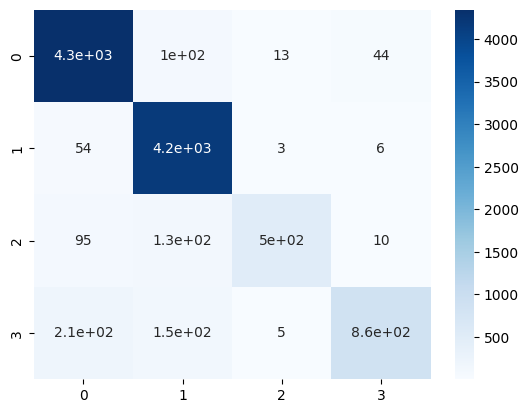

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 学習データ
train_cm = confusion_matrix(train['CATEGORY'], train_pred[1])
sns.heatmap(train_cm, annot=True, cmap='Blues')
plt.show()
     

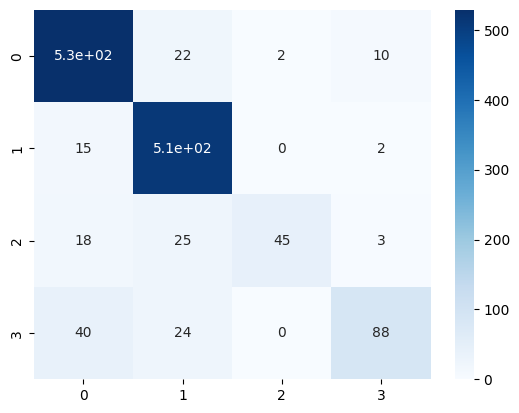

In [13]:
# 検証データ
test_cm = confusion_matrix(test['CATEGORY'], test_pred[1])
sns.heatmap(test_cm, annot=True, cmap='Blues')
plt.show()

# 56. 適合率，再現率，F1スコアの計測

In [14]:
from sklearn.metrics import classification_report

print(classification_report(test['CATEGORY'], test_pred[1], labels=['b', 'e', 'm', 't']))

              precision    recall  f1-score   support

           b       0.88      0.94      0.91       563
           e       0.88      0.97      0.92       528
           m       0.96      0.49      0.65        91
           t       0.85      0.58      0.69       152

    accuracy                           0.88      1334
   macro avg       0.89      0.75      0.79      1334
weighted avg       0.88      0.88      0.87      1334



# 57. 特徴量の重みの確認

In [15]:
features = X_train.columns.values

for cl, co in zip(lg.classes_, lg.coef_):
    print(f'カテゴリ : {cl}')
    bests = pd.DataFrame(features[np.argsort(co)[::-1][:10]], columns=['高い-10'], index=range(1,11)).T
    worsts = pd.DataFrame(features[np.argsort(co)[:10]], columns=['低い-10'], index=range(1,11)).T
    display(pd.concat([bests, worsts], axis=0))

カテゴリ : b


,1,2,3,4,5,6,7,8,9,10
高い-10,bank,fed,ecb,china,stocks,oil,obamacare,euro,dollar,ukraine
低い-10,her,ebola,and,apple,facebook,video,star,drug,microsoft,study


カテゴリ : e


,1,2,3,4,5,6,7,8,9,10
高い-10,kardashian,chris,movie,wedding,kim,star,her,paul,george,film
低い-10,update,us,google,ceo,study,china,could,says,billion,gm


カテゴリ : m


,1,2,3,4,5,6,7,8,9,10
高い-10,ebola,cancer,study,drug,fda,mers,cdc,could,health,cases
低い-10,gm,facebook,climate,ceo,deal,apple,twitter,sales,profit,google


カテゴリ : t


,1,2,3,4,5,6,7,8,9,10
高い-10,google,facebook,apple,microsoft,climate,mobile,moon,heartbleed,gm,samsung
低い-10,drug,her,american,stocks,cancer,home,shares,before,fed,his


In [16]:
from tqdm import tqdm

result = []
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
  # モデルの学習
  lg = LogisticRegression(random_state=42, max_iter=10000, C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  train_pred = score(lg, X_train)
  valid_pred = score(lg, X_valid)
  test_pred = score(lg, X_test)

  # 正解率の算出
  train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])
  test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])

  # 結果の格納
  result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


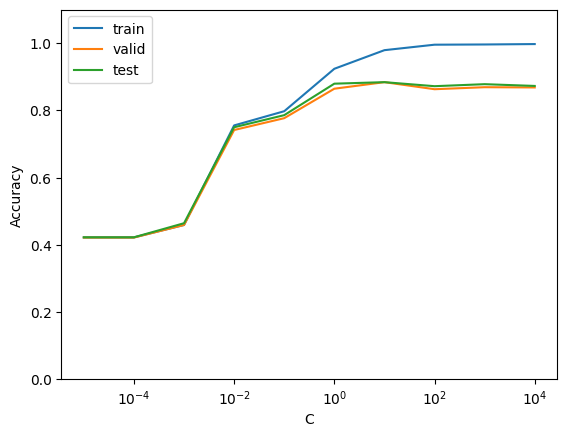

In [17]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

# 59. ハイパーパラメータの探索

In [49]:
import optuna
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

def objective(trial):

    learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)
    num_leaves =  trial.suggest_int("num_leaves", 5, 50)
    
    params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'num_class': 4,
            'objective': 'multiclass',       
            'metric': 'multi_logloss',      
            'learning_rate': learning_rate,
            'num_leaves': num_leaves,
            'seed': 42
            }
    category_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
    train_label = train['CATEGORY'].map(lambda x: category_dict[x])
    valid_label = valid['CATEGORY'].map(lambda x: category_dict[x])

    train_data = lgb.Dataset(X_train, label=train_label)
    valid_data = lgb.Dataset(X_valid, label=valid_label, reference=train_data)

    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['Train', 'Valid'],
        num_boost_round=100,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=1),
                lgb.log_evaluation(-1)],
        )

    
    # 推論
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)
    # 評価
    acc = accuracy_score(valid_label, y_pred)

    return acc


In [50]:
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200)


[I 2024-02-29 00:34:01,338] A new study created in memory with name: no-name-8a40afe2-4dbb-495e-b809-88b581ec5955
/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:04,974] Trial 0 finished with value: 0.8365817091454273 and parameters: {'learning_rate': 0.37516557872851514, 'num_leaves': 48}. Best is trial 0 with value: 0.8365817091454273.


Early stopping, best iteration is:
[22]	Train's multi_logloss: 0.217772	Valid's multi_logloss: 0.47435
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:07,208] Trial 1 finished with value: 0.8313343328335832 and parameters: {'learning_rate': 0.7322619478695936, 'num_leaves': 32}. Best is trial 0 with value: 0.8365817091454273.


Early stopping, best iteration is:
[14]	Train's multi_logloss: 0.244847	Valid's multi_logloss: 0.495029
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:08,672] Trial 2 finished with value: 0.835832083958021 and parameters: {'learning_rate': 0.1568626218019941, 'num_leaves': 12}. Best is trial 0 with value: 0.8365817091454273.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.371698	Valid's multi_logloss: 0.50436
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:13,225] Trial 3 finished with value: 0.8343328335832084 and parameters: {'learning_rate': 0.05902552855603126, 'num_leaves': 44}. Best is trial 0 with value: 0.8365817091454273.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.300051	Valid's multi_logloss: 0.475267
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:15,907] Trial 4 finished with value: 0.8380809595202399 and parameters: {'learning_rate': 0.6015138967314656, 'num_leaves': 37}. Best is trial 4 with value: 0.8380809595202399.


Early stopping, best iteration is:
[17]	Train's multi_logloss: 0.223113	Valid's multi_logloss: 0.488019
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:20,948] Trial 5 finished with value: 0.8088455772113943 and parameters: {'learning_rate': 0.021563909801506645, 'num_leaves': 49}. Best is trial 4 with value: 0.8380809595202399.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.487564	Valid's multi_logloss: 0.582299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:22,252] Trial 6 finished with value: 0.8290854572713643 and parameters: {'learning_rate': 0.8326101981596213, 'num_leaves': 14}. Best is trial 4 with value: 0.8380809595202399.


Early stopping, best iteration is:
[28]	Train's multi_logloss: 0.254526	Valid's multi_logloss: 0.512331
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:23,798] Trial 7 finished with value: 0.8463268365817092 and parameters: {'learning_rate': 0.18264314223989353, 'num_leaves': 13}. Best is trial 7 with value: 0.8463268365817092.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.329761	Valid's multi_logloss: 0.484538
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:26,663] Trial 8 finished with value: 0.8320839580209896 and parameters: {'learning_rate': 0.3049380007165782, 'num_leaves': 29}. Best is trial 7 with value: 0.8463268365817092.


Early stopping, best iteration is:
[44]	Train's multi_logloss: 0.230065	Valid's multi_logloss: 0.465763
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:28,477] Trial 9 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.43251307362347363, 'num_leaves': 18}. Best is trial 7 with value: 0.8463268365817092.


Early stopping, best iteration is:
[40]	Train's multi_logloss: 0.271539	Valid's multi_logloss: 0.462304
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:29,253] Trial 10 finished with value: 0.820839580209895 and parameters: {'learning_rate': 0.2084112227798961, 'num_leaves': 5}. Best is trial 7 with value: 0.8463268365817092.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.49867	Valid's multi_logloss: 0.579024
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:31,066] Trial 11 finished with value: 0.8350824587706147 and parameters: {'learning_rate': 0.49786161513156957, 'num_leaves': 20}. Best is trial 7 with value: 0.8463268365817092.


Early stopping, best iteration is:
[30]	Train's multi_logloss: 0.274966	Valid's multi_logloss: 0.468599
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:33,058] Trial 12 finished with value: 0.8350824587706147 and parameters: {'learning_rate': 0.4436372111879819, 'num_leaves': 21}. Best is trial 7 with value: 0.8463268365817092.


Early stopping, best iteration is:
[36]	Train's multi_logloss: 0.256586	Valid's multi_logloss: 0.475129
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:34,663] Trial 13 finished with value: 0.8343328335832084 and parameters: {'learning_rate': 0.6350576164745018, 'num_leaves': 19}. Best is trial 7 with value: 0.8463268365817092.


Early stopping, best iteration is:
[24]	Train's multi_logloss: 0.274424	Valid's multi_logloss: 0.48165
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:35,181] Trial 14 finished with value: 0.7113943028485757 and parameters: {'learning_rate': 0.9470149145137592, 'num_leaves': 5}. Best is trial 7 with value: 0.8463268365817092.


Early stopping, best iteration is:
[5]	Train's multi_logloss: 0.842231	Valid's multi_logloss: 0.873936
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:36,823] Trial 15 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.2814801932854645, 'num_leaves': 14}. Best is trial 7 with value: 0.8463268365817092.


Did not meet early stopping. Best iteration is:
[92]	Train's multi_logloss: 0.256772	Valid's multi_logloss: 0.470892
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:38,178] Trial 16 finished with value: 0.8500749625187406 and parameters: {'learning_rate': 0.24892054289682974, 'num_leaves': 11}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.30965	Valid's multi_logloss: 0.475105
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:39,441] Trial 17 finished with value: 0.8335832083958021 and parameters: {'learning_rate': 0.14242174464033497, 'num_leaves': 10}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.423055	Valid's multi_logloss: 0.528447
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:40,602] Trial 18 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.303139833945798, 'num_leaves': 9}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.313827	Valid's multi_logloss: 0.478154
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:43,442] Trial 19 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.10140864971070088, 'num_leaves': 26}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.300159	Valid's multi_logloss: 0.473474
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:46,138] Trial 20 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.22625893513679257, 'num_leaves': 25}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[69]	Train's multi_logloss: 0.233947	Valid's multi_logloss: 0.465548
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:47,784] Trial 21 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.29512412007329214, 'num_leaves': 14}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[91]	Train's multi_logloss: 0.250786	Valid's multi_logloss: 0.470105
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:49,510] Trial 22 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.3482857970660862, 'num_leaves': 15}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[65]	Train's multi_logloss: 0.263361	Valid's multi_logloss: 0.467013
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:50,579] Trial 23 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.22244543219869614, 'num_leaves': 8}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.39082	Valid's multi_logloss: 0.513797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:52,511] Trial 24 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.22527969060066338, 'num_leaves': 17}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[96]	Train's multi_logloss: 0.250253	Valid's multi_logloss: 0.468045
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:55,159] Trial 25 finished with value: 0.7338830584707646 and parameters: {'learning_rate': 0.006465855835407597, 'num_leaves': 24}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.835465	Valid's multi_logloss: 0.854749
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:56,496] Trial 26 finished with value: 0.8343328335832084 and parameters: {'learning_rate': 0.583643926812361, 'num_leaves': 11}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[78]	Train's multi_logloss: 0.201041	Valid's multi_logloss: 0.484161
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:34:59,178] Trial 27 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.4015550137123619, 'num_leaves': 34}. Best is trial 16 with value: 0.8500749625187406.


Early stopping, best iteration is:
[25]	Train's multi_logloss: 0.246923	Valid's multi_logloss: 0.469456
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:01,722] Trial 28 finished with value: 0.8373313343328336 and parameters: {'learning_rate': 0.15235338246818092, 'num_leaves': 23}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.254071	Valid's multi_logloss: 0.462492
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:03,531] Trial 29 finished with value: 0.8380809595202399 and parameters: {'learning_rate': 0.5038242079076705, 'num_leaves': 16}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[53]	Train's multi_logloss: 0.220724	Valid's multi_logloss: 0.472976
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:04,497] Trial 30 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.3534412886086051, 'num_leaves': 7}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[98]	Train's multi_logloss: 0.34151	Valid's multi_logloss: 0.488078
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:05,464] Trial 31 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.3569259244979443, 'num_leaves': 7}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.335	Valid's multi_logloss: 0.48824
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:07,076] Trial 32 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.28774769509977394, 'num_leaves': 13}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[99]	Train's multi_logloss: 0.255324	Valid's multi_logloss: 0.464314
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:08,449] Trial 33 finished with value: 0.8178410794602698 and parameters: {'learning_rate': 0.0982582104656298, 'num_leaves': 11}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.468918	Valid's multi_logloss: 0.560632
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:09,518] Trial 34 finished with value: 0.8343328335832084 and parameters: {'learning_rate': 0.2505608882406764, 'num_leaves': 8}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.369462	Valid's multi_logloss: 0.503513
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:13,899] Trial 35 finished with value: 0.8373313343328336 and parameters: {'learning_rate': 0.1715826540879795, 'num_leaves': 44}. Best is trial 16 with value: 0.8500749625187406.


Early stopping, best iteration is:
[48]	Train's multi_logloss: 0.237939	Valid's multi_logloss: 0.464874
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:15,343] Trial 36 finished with value: 0.8388305847076462 and parameters: {'learning_rate': 0.3655493876427473, 'num_leaves': 12}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[87]	Train's multi_logloss: 0.250591	Valid's multi_logloss: 0.46883
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:16,114] Trial 37 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.49343496069114606, 'num_leaves': 5}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.345266	Valid's multi_logloss: 0.502733
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:20,062] Trial 38 finished with value: 0.8328335832083958 and parameters: {'learning_rate': 0.11144570156281836, 'num_leaves': 38}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[95]	Train's multi_logloss: 0.224219	Valid's multi_logloss: 0.463932
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:23,020] Trial 39 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.2652415437553308, 'num_leaves': 28}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[61]	Train's multi_logloss: 0.205755	Valid's multi_logloss: 0.462896
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:25,488] Trial 40 finished with value: 0.8268365817091454 and parameters: {'learning_rate': 0.05953228715597636, 'num_leaves': 22}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.42525	Valid's multi_logloss: 0.534986
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:27,129] Trial 41 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.3290831076959723, 'num_leaves': 14}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[84]	Train's multi_logloss: 0.244305	Valid's multi_logloss: 0.466101
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:29,068] Trial 42 finished with value: 0.8455772113943029 and parameters: {'learning_rate': 0.19269520319343597, 'num_leaves': 17}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.270663	Valid's multi_logloss: 0.467342
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:31,103] Trial 43 finished with value: 0.8463268365817092 and parameters: {'learning_rate': 0.18459927657926575, 'num_leaves': 18}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[99]	Train's multi_logloss: 0.268551	Valid's multi_logloss: 0.465666
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:33,145] Trial 44 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.18931531923840528, 'num_leaves': 18}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[99]	Train's multi_logloss: 0.264245	Valid's multi_logloss: 0.465891
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:35,406] Trial 45 finished with value: 0.8058470764617691 and parameters: {'learning_rate': 0.04292315745907993, 'num_leaves': 20}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.502066	Valid's multi_logloss: 0.585584
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:36,374] Trial 46 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.4222578638172928, 'num_leaves': 7}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.305159	Valid's multi_logloss: 0.482237
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:38,313] Trial 47 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.18601925668005564, 'num_leaves': 17}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[98]	Train's multi_logloss: 0.280263	Valid's multi_logloss: 0.469262
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:39,594] Trial 48 finished with value: 0.8275862068965517 and parameters: {'learning_rate': 0.11898596578113474, 'num_leaves': 10}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.454054	Valid's multi_logloss: 0.548274
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:41,086] Trial 49 finished with value: 0.7991004497751124 and parameters: {'learning_rate': 0.061004344268404384, 'num_leaves': 12}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.535185	Valid's multi_logloss: 0.607162
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:42,927] Trial 50 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.25457278051916266, 'num_leaves': 16}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[98]	Train's multi_logloss: 0.238291	Valid's multi_logloss: 0.464032
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:45,157] Trial 51 finished with value: 0.8448275862068966 and parameters: {'learning_rate': 0.18065752025737064, 'num_leaves': 20}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[93]	Train's multi_logloss: 0.262713	Valid's multi_logloss: 0.463743
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:47,294] Trial 52 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.17187020414158213, 'num_leaves': 19}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.268719	Valid's multi_logloss: 0.469925
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:49,650] Trial 53 finished with value: 0.8373313343328336 and parameters: {'learning_rate': 0.32208308442943345, 'num_leaves': 21}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[62]	Train's multi_logloss: 0.222639	Valid's multi_logloss: 0.464826
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:50,999] Trial 54 finished with value: 0.8365817091454273 and parameters: {'learning_rate': 0.771467959936373, 'num_leaves': 15}. Best is trial 16 with value: 0.8500749625187406.


Early stopping, best iteration is:
[26]	Train's multi_logloss: 0.266524	Valid's multi_logloss: 0.495185
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:52,162] Trial 55 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.2186948397967902, 'num_leaves': 9}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.369435	Valid's multi_logloss: 0.501384
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:54,011] Trial 56 finished with value: 0.8193403298350824 and parameters: {'learning_rate': 0.9962291590208401, 'num_leaves': 30}. Best is trial 16 with value: 0.8500749625187406.


Early stopping, best iteration is:
[8]	Train's multi_logloss: 0.468963	Valid's multi_logloss: 0.667351
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:55,590] Trial 57 finished with value: 0.8335832083958021 and parameters: {'learning_rate': 0.1296080955203823, 'num_leaves': 13}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.388398	Valid's multi_logloss: 0.512823
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:35:57,647] Trial 58 finished with value: 0.8320839580209896 and parameters: {'learning_rate': 0.09136971290646978, 'num_leaves': 18}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.386613	Valid's multi_logloss: 0.51275
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:00,422] Trial 59 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.2491355108878223, 'num_leaves': 26}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[71]	Train's multi_logloss: 0.204566	Valid's multi_logloss: 0.468381
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:01,290] Trial 60 finished with value: 0.8470764617691154 and parameters: {'learning_rate': 0.3952118572986786, 'num_leaves': 6}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.347934	Valid's multi_logloss: 0.494182
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:02,061] Trial 61 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.40506192940674357, 'num_leaves': 5}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.380449	Valid's multi_logloss: 0.51208
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:03,026] Trial 62 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.4619419552235097, 'num_leaves': 7}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.288755	Valid's multi_logloss: 0.469374
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:04,278] Trial 63 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.3828756375960808, 'num_leaves': 10}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[97]	Train's multi_logloss: 0.260694	Valid's multi_logloss: 0.468775
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:05,148] Trial 64 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.3170664183749865, 'num_leaves': 6}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.386815	Valid's multi_logloss: 0.512183
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:06,313] Trial 65 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.20807205607502613, 'num_leaves': 9}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.378354	Valid's multi_logloss: 0.507905
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:07,659] Trial 66 finished with value: 0.8320839580209896 and parameters: {'learning_rate': 0.5569767286859162, 'num_leaves': 11}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[68]	Train's multi_logloss: 0.232653	Valid's multi_logloss: 0.47657
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:09,491] Trial 67 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.2851009794433097, 'num_leaves': 16}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[89]	Train's multi_logloss: 0.234835	Valid's multi_logloss: 0.467128
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:11,044] Trial 68 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.23863200576092852, 'num_leaves': 13}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[98]	Train's multi_logloss: 0.288221	Valid's multi_logloss: 0.466683
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:13,575] Trial 69 finished with value: 0.8380809595202399 and parameters: {'learning_rate': 0.1355888558812105, 'num_leaves': 23}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.273851	Valid's multi_logloss: 0.465819
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:14,646] Trial 70 finished with value: 0.8305847076461769 and parameters: {'learning_rate': 0.15572088903387832, 'num_leaves': 8}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.451558	Valid's multi_logloss: 0.54671
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:16,872] Trial 71 finished with value: 0.8380809595202399 and parameters: {'learning_rate': 0.19559284126115323, 'num_leaves': 20}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[91]	Train's multi_logloss: 0.252655	Valid's multi_logloss: 0.46465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:18,809] Trial 72 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.1960908614689928, 'num_leaves': 17}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.267972	Valid's multi_logloss: 0.464467
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:20,830] Trial 73 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.3424084001132399, 'num_leaves': 18}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[58]	Train's multi_logloss: 0.249778	Valid's multi_logloss: 0.463426
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:22,982] Trial 74 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.1627285767084582, 'num_leaves': 19}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[98]	Train's multi_logloss: 0.281232	Valid's multi_logloss: 0.46651
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:24,724] Trial 75 finished with value: 0.8335832083958021 and parameters: {'learning_rate': 0.2854337616338595, 'num_leaves': 15}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.227859	Valid's multi_logloss: 0.468494
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:26,135] Trial 76 finished with value: 0.8223388305847077 and parameters: {'learning_rate': 0.09709699655715309, 'num_leaves': 11}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.471013	Valid's multi_logloss: 0.55918
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:28,426] Trial 77 finished with value: 0.8335832083958021 and parameters: {'learning_rate': 0.45470607181002987, 'num_leaves': 22}. Best is trial 16 with value: 0.8500749625187406.


Early stopping, best iteration is:
[46]	Train's multi_logloss: 0.204802	Valid's multi_logloss: 0.478295
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:29,966] Trial 78 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.3719292228895136, 'num_leaves': 13}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[98]	Train's multi_logloss: 0.213557	Valid's multi_logloss: 0.468771
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:31,134] Trial 79 finished with value: 0.8463268365817092 and parameters: {'learning_rate': 0.22865142038900033, 'num_leaves': 9}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.361929	Valid's multi_logloss: 0.498125
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:32,007] Trial 80 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.27616091053576003, 'num_leaves': 6}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.411079	Valid's multi_logloss: 0.526422
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:33,175] Trial 81 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.22067111909450518, 'num_leaves': 9}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.368814	Valid's multi_logloss: 0.503537
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:34,952] Trial 82 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.17755583945614395, 'num_leaves': 15}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[99]	Train's multi_logloss: 0.309877	Valid's multi_logloss: 0.476133
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:35,925] Trial 83 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.23671280404364012, 'num_leaves': 7}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.406082	Valid's multi_logloss: 0.522605
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:37,376] Trial 84 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.30594364495486126, 'num_leaves': 12}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.257704	Valid's multi_logloss: 0.466088
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:39,036] Trial 85 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.15030211700833146, 'num_leaves': 14}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.348787	Valid's multi_logloss: 0.494531
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:40,304] Trial 86 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.19422342461326597, 'num_leaves': 10}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.370041	Valid's multi_logloss: 0.504267
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:41,380] Trial 87 finished with value: 0.7961019490254873 and parameters: {'learning_rate': 0.08158280529552346, 'num_leaves': 8}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.563701	Valid's multi_logloss: 0.626006
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:42,259] Trial 88 finished with value: 0.732383808095952 and parameters: {'learning_rate': 0.0315700544520881, 'num_leaves': 6}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.773271	Valid's multi_logloss: 0.793603
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:44,192] Trial 89 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.2471203049030572, 'num_leaves': 17}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[92]	Train's multi_logloss: 0.243175	Valid's multi_logloss: 0.466767
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:45,558] Trial 90 finished with value: 0.8320839580209896 and parameters: {'learning_rate': 0.13153718774763326, 'num_leaves': 11}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.417994	Valid's multi_logloss: 0.528306
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:46,526] Trial 91 finished with value: 0.8455772113943029 and parameters: {'learning_rate': 0.416761455397451, 'num_leaves': 7}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.307032	Valid's multi_logloss: 0.48205
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:47,301] Trial 92 finished with value: 0.8365817091454273 and parameters: {'learning_rate': 0.47661572377958006, 'num_leaves': 5}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.352208	Valid's multi_logloss: 0.501571
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:48,275] Trial 93 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.431468788348808, 'num_leaves': 7}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.301067	Valid's multi_logloss: 0.482043
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:49,718] Trial 94 finished with value: 0.8448275862068966 and parameters: {'learning_rate': 0.4042798105763111, 'num_leaves': 12}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[84]	Train's multi_logloss: 0.238014	Valid's multi_logloss: 0.470318
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:51,160] Trial 95 finished with value: 0.8448275862068966 and parameters: {'learning_rate': 0.39714786412389214, 'num_leaves': 12}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[63]	Train's multi_logloss: 0.288031	Valid's multi_logloss: 0.470364
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:52,690] Trial 96 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.5126809200463984, 'num_leaves': 13}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[59]	Train's multi_logloss: 0.239335	Valid's multi_logloss: 0.472591
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:53,949] Trial 97 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.39380023190494834, 'num_leaves': 10}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[93]	Train's multi_logloss: 0.26046	Valid's multi_logloss: 0.4731
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:55,385] Trial 98 finished with value: 0.8343328335832084 and parameters: {'learning_rate': 0.6483780219707835, 'num_leaves': 12}. Best is trial 16 with value: 0.8500749625187406.


Did not meet early stopping. Best iteration is:
[54]	Train's multi_logloss: 0.224978	Valid's multi_logloss: 0.494354
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:56,550] Trial 99 finished with value: 0.8508245877061469 and parameters: {'learning_rate': 0.33329151644262134, 'num_leaves': 9}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.29932	Valid's multi_logloss: 0.470064
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:57,622] Trial 100 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.33964184275197973, 'num_leaves': 8}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.317854	Valid's multi_logloss: 0.484794
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:36:58,777] Trial 101 finished with value: 0.8448275862068966 and parameters: {'learning_rate': 0.426668174201858, 'num_leaves': 9}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[94]	Train's multi_logloss: 0.265927	Valid's multi_logloss: 0.46688
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:00,220] Trial 102 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.3704349396875594, 'num_leaves': 12}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[86]	Train's multi_logloss: 0.25013	Valid's multi_logloss: 0.46558
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:03,439] Trial 103 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.40764429878904096, 'num_leaves': 44}. Best is trial 99 with value: 0.8508245877061469.


Early stopping, best iteration is:
[21]	Train's multi_logloss: 0.22632	Valid's multi_logloss: 0.472212
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:04,994] Trial 104 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.5311251630843759, 'num_leaves': 14}. Best is trial 99 with value: 0.8508245877061469.


Early stopping, best iteration is:
[44]	Train's multi_logloss: 0.265531	Valid's multi_logloss: 0.477963
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:06,832] Trial 105 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.26350546214128123, 'num_leaves': 16}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[91]	Train's multi_logloss: 0.245181	Valid's multi_logloss: 0.462833
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:08,189] Trial 106 finished with value: 0.8448275862068966 and parameters: {'learning_rate': 0.3150018141660802, 'num_leaves': 11}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[94]	Train's multi_logloss: 0.280126	Valid's multi_logloss: 0.473752
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:09,439] Trial 107 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.47387697362795866, 'num_leaves': 10}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[79]	Train's multi_logloss: 0.255164	Valid's multi_logloss: 0.470043
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:12,727] Trial 108 finished with value: 0.8350824587706147 and parameters: {'learning_rate': 0.4432143754691393, 'num_leaves': 48}. Best is trial 99 with value: 0.8508245877061469.


Early stopping, best iteration is:
[17]	Train's multi_logloss: 0.233396	Valid's multi_logloss: 0.471673
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:13,600] Trial 109 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.35661993975758105, 'num_leaves': 6}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.366139	Valid's multi_logloss: 0.509688
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:14,793] Trial 110 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.21174801968090873, 'num_leaves': 9}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.375837	Valid's multi_logloss: 0.506863
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:15,974] Trial 111 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.3903996757726194, 'num_leaves': 9}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[87]	Train's multi_logloss: 0.293529	Valid's multi_logloss: 0.477266
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:17,056] Trial 112 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.4151467895054558, 'num_leaves': 8}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.281954	Valid's multi_logloss: 0.470362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:19,073] Trial 113 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.3355620604801386, 'num_leaves': 15}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[77]	Train's multi_logloss: 0.243348	Valid's multi_logloss: 0.466078
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:20,328] Trial 114 finished with value: 0.8470764617691154 and parameters: {'learning_rate': 0.29679989467691986, 'num_leaves': 10}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.29783	Valid's multi_logloss: 0.477645
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:21,885] Trial 115 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.2666042444395393, 'num_leaves': 13}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[94]	Train's multi_logloss: 0.276658	Valid's multi_logloss: 0.465968
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:23,172] Trial 116 finished with value: 0.835832083958021 and parameters: {'learning_rate': 0.17004828680666262, 'num_leaves': 10}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.392635	Valid's multi_logloss: 0.51321
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:26,174] Trial 117 finished with value: 0.8305847076461769 and parameters: {'learning_rate': 0.3013155111567536, 'num_leaves': 33}. Best is trial 99 with value: 0.8508245877061469.


Early stopping, best iteration is:
[37]	Train's multi_logloss: 0.238837	Valid's multi_logloss: 0.470516
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:27,557] Trial 118 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.22966804674692942, 'num_leaves': 11}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.321935	Valid's multi_logloss: 0.482588
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:28,428] Trial 119 finished with value: 0.8373313343328336 and parameters: {'learning_rate': 0.32486509662605, 'num_leaves': 6}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.382856	Valid's multi_logloss: 0.512555
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:29,897] Trial 120 finished with value: 0.8365817091454273 and parameters: {'learning_rate': 0.2921333031474249, 'num_leaves': 12}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.264566	Valid's multi_logloss: 0.472092
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:31,049] Trial 121 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.37597458014538854, 'num_leaves': 9}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[99]	Train's multi_logloss: 0.280795	Valid's multi_logloss: 0.470363
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:32,106] Trial 122 finished with value: 0.8470764617691154 and parameters: {'learning_rate': 0.4333755578663134, 'num_leaves': 8}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.273926	Valid's multi_logloss: 0.472339
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:33,166] Trial 123 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.39586455921101055, 'num_leaves': 8}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[99]	Train's multi_logloss: 0.292954	Valid's multi_logloss: 0.473955
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:34,127] Trial 124 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.445100982476545, 'num_leaves': 7}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.297024	Valid's multi_logloss: 0.476989
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:36,584] Trial 125 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.35329355843791016, 'num_leaves': 21}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[56]	Train's multi_logloss: 0.224407	Valid's multi_logloss: 0.462241
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:38,533] Trial 126 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.46196980605560334, 'num_leaves': 19}. Best is trial 99 with value: 0.8508245877061469.


Early stopping, best iteration is:
[41]	Train's multi_logloss: 0.245779	Valid's multi_logloss: 0.466449
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:40,235] Trial 127 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.2164311066186763, 'num_leaves': 14}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[98]	Train's multi_logloss: 0.290989	Valid's multi_logloss: 0.47222
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:41,756] Trial 128 finished with value: 0.8373313343328336 and parameters: {'learning_rate': 0.4876934648972256, 'num_leaves': 11}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[77]	Train's multi_logloss: 0.236698	Valid's multi_logloss: 0.477853
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:42,892] Trial 129 finished with value: 0.8350824587706147 and parameters: {'learning_rate': 0.18651137881856644, 'num_leaves': 8}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.420744	Valid's multi_logloss: 0.5283
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:43,833] Trial 130 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.41880342934268067, 'num_leaves': 5}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.375229	Valid's multi_logloss: 0.507825
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:45,084] Trial 131 finished with value: 0.8328335832083958 and parameters: {'learning_rate': 0.42943398036173336, 'num_leaves': 10}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.235458	Valid's multi_logloss: 0.480795
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:46,244] Trial 132 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.25177588093545056, 'num_leaves': 9}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.34568	Valid's multi_logloss: 0.495108
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:47,220] Trial 133 finished with value: 0.8298350824587706 and parameters: {'learning_rate': 0.8829401354360419, 'num_leaves': 7}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[97]	Train's multi_logloss: 0.181245	Valid's multi_logloss: 0.527618
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:48,752] Trial 134 finished with value: 0.8388305847076462 and parameters: {'learning_rate': 0.3823098795091789, 'num_leaves': 13}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[87]	Train's multi_logloss: 0.228194	Valid's multi_logloss: 0.471194
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:50,234] Trial 135 finished with value: 0.835832083958021 and parameters: {'learning_rate': 0.15209547754000535, 'num_leaves': 12}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.376365	Valid's multi_logloss: 0.504557
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:51,464] Trial 136 finished with value: 0.835832083958021 and parameters: {'learning_rate': 0.5184109121032523, 'num_leaves': 9}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[94]	Train's multi_logloss: 0.229899	Valid's multi_logloss: 0.476041
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:52,816] Trial 137 finished with value: 0.8365817091454273 and parameters: {'learning_rate': 0.4339152964868289, 'num_leaves': 11}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[85]	Train's multi_logloss: 0.242174	Valid's multi_logloss: 0.46642
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:54,630] Trial 138 finished with value: 0.8388305847076462 and parameters: {'learning_rate': 0.40899659173381697, 'num_leaves': 16}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[73]	Train's multi_logloss: 0.207402	Valid's multi_logloss: 0.46573
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:55,497] Trial 139 finished with value: 0.8388305847076462 and parameters: {'learning_rate': 0.2755217254201685, 'num_leaves': 6}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.411494	Valid's multi_logloss: 0.52397
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:56,530] Trial 140 finished with value: 0.8095952023988006 and parameters: {'learning_rate': 0.12226834402977538, 'num_leaves': 7}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.521015	Valid's multi_logloss: 0.594188
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:57,793] Trial 141 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.33044470777340573, 'num_leaves': 10}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.279516	Valid's multi_logloss: 0.472201
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:37:59,139] Trial 142 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.3049999828162443, 'num_leaves': 11}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[98]	Train's multi_logloss: 0.279129	Valid's multi_logloss: 0.467431
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:00,580] Trial 143 finished with value: 0.8463268365817092 and parameters: {'learning_rate': 0.20141305274211624, 'num_leaves': 12}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.328284	Valid's multi_logloss: 0.480583
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:02,219] Trial 144 finished with value: 0.8470764617691154 and parameters: {'learning_rate': 0.19533496712035658, 'num_leaves': 14}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.3041	Valid's multi_logloss: 0.474849
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:04,138] Trial 145 finished with value: 0.8448275862068966 and parameters: {'learning_rate': 0.19604489929100163, 'num_leaves': 17}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.268135	Valid's multi_logloss: 0.462964
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:05,923] Trial 146 finished with value: 0.8455772113943029 and parameters: {'learning_rate': 0.21184543739078426, 'num_leaves': 15}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.278098	Valid's multi_logloss: 0.469478
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:08,008] Trial 147 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.17837790579461843, 'num_leaves': 18}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.2721	Valid's multi_logloss: 0.470384
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:09,667] Trial 148 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.21000705135224784, 'num_leaves': 14}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.292168	Valid's multi_logloss: 0.475127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:11,522] Trial 149 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.23194052509802313, 'num_leaves': 16}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[98]	Train's multi_logloss: 0.254508	Valid's multi_logloss: 0.469315
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:13,144] Trial 150 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.1422634506724818, 'num_leaves': 13}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.372265	Valid's multi_logloss: 0.502709
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:14,603] Trial 151 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.20305129136043917, 'num_leaves': 12}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.327049	Valid's multi_logloss: 0.484149
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:16,344] Trial 152 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.1647529508791883, 'num_leaves': 15}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.320999	Valid's multi_logloss: 0.479724
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:18,068] Trial 153 finished with value: 0.8455772113943029 and parameters: {'learning_rate': 0.2475450130796769, 'num_leaves': 15}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[88]	Train's multi_logloss: 0.272588	Valid's multi_logloss: 0.466944
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:19,728] Trial 154 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.2320334830343452, 'num_leaves': 14}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.276027	Valid's multi_logloss: 0.468437
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:21,528] Trial 155 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.2553289404410297, 'num_leaves': 15}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[98]	Train's multi_logloss: 0.250868	Valid's multi_logloss: 0.465725
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:23,748] Trial 156 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.24642401466904457, 'num_leaves': 20}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[71]	Train's multi_logloss: 0.25471	Valid's multi_logloss: 0.461369
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:25,685] Trial 157 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.17839974103349537, 'num_leaves': 17}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.28302	Valid's multi_logloss: 0.469704
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:27,223] Trial 158 finished with value: 0.8448275862068966 and parameters: {'learning_rate': 0.26653891074033553, 'num_leaves': 13}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[94]	Train's multi_logloss: 0.27604	Valid's multi_logloss: 0.466698
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:29,056] Trial 159 finished with value: 0.8470764617691154 and parameters: {'learning_rate': 0.2225909554907003, 'num_leaves': 16}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[97]	Train's multi_logloss: 0.262088	Valid's multi_logloss: 0.463193
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:31,074] Trial 160 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.19099785082180076, 'num_leaves': 18}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.260907	Valid's multi_logloss: 0.469152
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:32,968] Trial 161 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.23207059710612063, 'num_leaves': 16}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.250839	Valid's multi_logloss: 0.467812
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:34,702] Trial 162 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.21644718573588767, 'num_leaves': 15}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.273337	Valid's multi_logloss: 0.469303
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:36,667] Trial 163 finished with value: 0.8455772113943029 and parameters: {'learning_rate': 0.159957542040836, 'num_leaves': 17}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.301737	Valid's multi_logloss: 0.476517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:38,702] Trial 164 finished with value: 0.8470764617691154 and parameters: {'learning_rate': 0.16105145739677218, 'num_leaves': 18}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.289729	Valid's multi_logloss: 0.470606
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:40,635] Trial 165 finished with value: 0.8380809595202399 and parameters: {'learning_rate': 0.15979983357650998, 'num_leaves': 17}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.302452	Valid's multi_logloss: 0.47375
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:44,553] Trial 166 finished with value: 0.835832083958021 and parameters: {'learning_rate': 0.13927235449038583, 'num_leaves': 38}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[73]	Train's multi_logloss: 0.229896	Valid's multi_logloss: 0.464062
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:46,428] Trial 167 finished with value: 0.8425787106446777 and parameters: {'learning_rate': 0.11842603931597921, 'num_leaves': 16}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.364843	Valid's multi_logloss: 0.499104
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:48,547] Trial 168 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.20314342130360047, 'num_leaves': 19}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[94]	Train's multi_logloss: 0.250621	Valid's multi_logloss: 0.464651
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:50,573] Trial 169 finished with value: 0.8380809595202399 and parameters: {'learning_rate': 0.28240592339535203, 'num_leaves': 18}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[81]	Train's multi_logloss: 0.230248	Valid's multi_logloss: 0.471815
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:52,224] Trial 170 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.2205872512881263, 'num_leaves': 14}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[99]	Train's multi_logloss: 0.284853	Valid's multi_logloss: 0.470693
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:54,384] Trial 171 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.17343123360146145, 'num_leaves': 19}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.267037	Valid's multi_logloss: 0.465009
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:56,374] Trial 172 finished with value: 0.8463268365817092 and parameters: {'learning_rate': 0.15286489847761747, 'num_leaves': 17}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.309068	Valid's multi_logloss: 0.476366
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:38:58,324] Trial 173 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.15516664681792885, 'num_leaves': 16}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.318642	Valid's multi_logloss: 0.480044
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:00,314] Trial 174 finished with value: 0.8455772113943029 and parameters: {'learning_rate': 0.19541842837903228, 'num_leaves': 17}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.269116	Valid's multi_logloss: 0.463984
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:02,077] Trial 175 finished with value: 0.823088455772114 and parameters: {'learning_rate': 0.08198870435577227, 'num_leaves': 15}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.440686	Valid's multi_logloss: 0.542065
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:03,149] Trial 176 finished with value: 0.8148425787106447 and parameters: {'learning_rate': 0.11023954285742563, 'num_leaves': 8}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.511683	Valid's multi_logloss: 0.587439
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:05,098] Trial 177 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.13701395827527557, 'num_leaves': 17}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.327847	Valid's multi_logloss: 0.479737
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:06,808] Trial 178 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.23977686361668468, 'num_leaves': 14}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[93]	Train's multi_logloss: 0.28173	Valid's multi_logloss: 0.468019
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:08,946] Trial 179 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.20748868341862436, 'num_leaves': 19}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.237116	Valid's multi_logloss: 0.462455
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:12,211] Trial 180 finished with value: 0.8335832083958021 and parameters: {'learning_rate': 0.1634639220028306, 'num_leaves': 31}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[75]	Train's multi_logloss: 0.234686	Valid's multi_logloss: 0.465723
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:14,152] Trial 181 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.18468551830389834, 'num_leaves': 17}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.278088	Valid's multi_logloss: 0.466538
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:15,940] Trial 182 finished with value: 0.8388305847076462 and parameters: {'learning_rate': 0.19426836431249592, 'num_leaves': 15}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.29272	Valid's multi_logloss: 0.474752
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:17,958] Trial 183 finished with value: 0.843328335832084 and parameters: {'learning_rate': 0.25562531795100996, 'num_leaves': 18}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[79]	Train's multi_logloss: 0.250354	Valid's multi_logloss: 0.466844
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:19,803] Trial 184 finished with value: 0.8448275862068966 and parameters: {'learning_rate': 0.22407937639575337, 'num_leaves': 16}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[96]	Train's multi_logloss: 0.262279	Valid's multi_logloss: 0.466646
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:21,754] Trial 185 finished with value: 0.8418290854572713 and parameters: {'learning_rate': 0.20272525443492131, 'num_leaves': 17}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.261914	Valid's multi_logloss: 0.469579
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:24,075] Trial 186 finished with value: 0.8403298350824587 and parameters: {'learning_rate': 0.17529178609612894, 'num_leaves': 21}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.246918	Valid's multi_logloss: 0.461079
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:25,631] Trial 187 finished with value: 0.8373313343328336 and parameters: {'learning_rate': 0.1522697425459958, 'num_leaves': 13}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.36141	Valid's multi_logloss: 0.498539
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:26,405] Trial 188 finished with value: 0.8343328335832084 and parameters: {'learning_rate': 0.2674947071083503, 'num_leaves': 5}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.455382	Valid's multi_logloss: 0.549624
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:28,433] Trial 189 finished with value: 0.8440779610194903 and parameters: {'learning_rate': 0.21136954379865508, 'num_leaves': 18}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[97]	Train's multi_logloss: 0.249478	Valid's multi_logloss: 0.463427
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:29,694] Trial 190 finished with value: 0.8448275862068966 and parameters: {'learning_rate': 0.2421746573502904, 'num_leaves': 10}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.332005	Valid's multi_logloss: 0.484897
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:31,839] Trial 191 finished with value: 0.8448275862068966 and parameters: {'learning_rate': 0.1803292176965071, 'num_leaves': 19}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.261108	Valid's multi_logloss: 0.465088
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:34,086] Trial 192 finished with value: 0.8388305847076462 and parameters: {'learning_rate': 0.19000461503416066, 'num_leaves': 20}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.242886	Valid's multi_logloss: 0.464489
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:35,931] Trial 193 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.13501799565262862, 'num_leaves': 16}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.341571	Valid's multi_logloss: 0.488401
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:37,978] Trial 194 finished with value: 0.8395802098950524 and parameters: {'learning_rate': 0.22684760957288055, 'num_leaves': 18}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[97]	Train's multi_logloss: 0.23734	Valid's multi_logloss: 0.466361
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:40,689] Trial 195 finished with value: 0.8365817091454273 and parameters: {'learning_rate': 0.1562252523076269, 'num_leaves': 25}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[99]	Train's multi_logloss: 0.236143	Valid's multi_logloss: 0.463874
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:42,615] Trial 196 finished with value: 0.8373313343328336 and parameters: {'learning_rate': 0.28699474931037766, 'num_leaves': 17}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[76]	Train's multi_logloss: 0.247086	Valid's multi_logloss: 0.472191
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:44,363] Trial 197 finished with value: 0.848575712143928 and parameters: {'learning_rate': 0.19675045091008156, 'num_leaves': 15}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.289845	Valid's multi_logloss: 0.467544
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:46,122] Trial 198 finished with value: 0.8478260869565217 and parameters: {'learning_rate': 0.2004982992609732, 'num_leaves': 15}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.287743	Valid's multi_logloss: 0.470783
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


/var/folders/d4/0c_l5jkx5_n985zcb0gf1ng00000gn/T/ipykernel_4343/3458071427.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.001, 1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds


[I 2024-02-29 00:39:47,903] Trial 199 finished with value: 0.841079460269865 and parameters: {'learning_rate': 0.21538740014920416, 'num_leaves': 15}. Best is trial 99 with value: 0.8508245877061469.


Did not meet early stopping. Best iteration is:
[100]	Train's multi_logloss: 0.274757	Valid's multi_logloss: 0.471406


In [51]:
print("=======ベストパラメータ========")
print(study.best_params)

=======ベストパラメータ========
{'learning_rate': 0.33329151644262134, 'num_leaves': 9}


In [52]:
study.best_params["learning_rate"]

0.33329151644262134

In [53]:
category_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
train_label = train['CATEGORY'].map(lambda x: category_dict[x])
valid_label = valid['CATEGORY'].map(lambda x: category_dict[x])
test_label = test['CATEGORY'].map(lambda x: category_dict[x])

train_data = lgb.Dataset(X_train, label=train_label)
valid_data = lgb.Dataset(X_valid, label=valid_label)
test_data = lgb.Dataset(X_test, label=test_label)

params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'num_class': 4,
        'objective': 'multiclass',       
        'metric': 'multi_logloss',      
        'learning_rate': study.best_params["learning_rate"],
        'num_leaves': study.best_params["num_leaves"],
        'seed': 42
        }
params.update(study.best_params)

train_data = lgb.Dataset(X_train, label=train_label)
valid_data = lgb.Dataset(X_valid, label=valid_label, reference=train_data)

model = lgb.train(
params=params,
train_set=train_data,
valid_sets=[train_data, valid_data],
valid_names=['Train', 'Valid'],
num_boost_round=10,
callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=1),
        lgb.log_evaluation(-1)],
)


# 推論
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = np.argmax(y_pred, axis=1)
# 評価
acc = accuracy_score(test_label, y_pred)
print(acc)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23274
[LightGBM] [Info] Number of data points in the train set: 10672, number of used features: 1127
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.863102
[LightGBM] [Info] Start training from score -0.927078
[LightGBM] [Info] Start training from score -2.169593
[LightGBM] [Info] Start training from score -2.685078
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10]	Train's multi_logloss: 0.672583	Valid's multi_logloss: 0.712981
0.767616191904048
